#  **Import Libs**

In [ ]:
!pip install -q torchmetrics
!pip install -q portalocker
!pip install -q wandb
!pip install -q torcheval

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import portalocker

import torchtext
import torchtext.models as models
from torchtext.data import get_tokenizer
from torchtext.datasets import WikiText2
from torchtext.vocab import build_vocab_from_iterator

import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset, random_split

from torch import optim
from torch.nn import functional as F

from torcheval.metrics.text import Perplexity

import tqdm
import torchmetrics as tm
import wandb

import io
import os
from collections import Counter

import ipywidgets as widgets
from IPython.display import display

#  **Utils**

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

#  **Dataset**

## 1- **Load the Dataset**

In [ ]:
# load WikiText2 dataset

from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Colab Notebooks/Howsam Projects/Data/1-language modeling/wikitext-2.zip' -d  '/content/'

## 2- **Build vocabulary and save it**

 In this section we Tokenize the dataset using `basic_english` and Build the vocabulary

In [ ]:
def text_read_iterator(token_path ):
  with io.open(token_path, encoding = 'utf-8') as f:
    for line in f:
      yield line

In [ ]:
tokenizer= get_tokenizer('basic_english')

# create vocabs, insert special tokens and set the default index
vocabs = build_vocab_from_iterator(map(tokenizer,text_read_iterator('/content/wikitext-2/wiki.train.tokens'))
,min_freq=1, specials=["<unk>"])

# this would prevent error and returns 0 index, if a word was not in the vocab
vocabs.set_default_index(vocabs['<unk>'])

## 3- **EDA**

###  Let's explore the WikiText2 dataset!

###  Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [ ]:
doc_count = 0
avg_sen_len=0
for sentence in text_read_iterator('/content/wikitext-2/wiki.train.tokens'):
  if(len(sentence)>0):
    doc_count+= 1
    avg_sen_len+= len(sentence)

print(f"Number of Documents: {doc_count}")
print(f"Average Doc Length: {avg_sen_len/doc_count}")



###  Analyze the most common and least common words in the dataset.

In [ ]:
word_freq = Counter()
for sentence in text_read_iterator('/content/wikitext-2/wiki.train.tokens'):
  word_freq.update(sentence.split())

word_freq.most_common()

In [ ]:
word_freq.most_common()[-10:]

###   Please proceed with further exploration of the dataset. what do you suggest?

In [ ]:
get =text_read_iterator('/content/wikitext-2/wiki.test.tokens')

In [ ]:
sentences =next(get).split('.')
sentences

In [ ]:
df = pd.DataFrame([sentences],columns=['txt'])
df['txt'].str.len().hist()

In [ ]:
x, y= [], []
for word,count in word_freq.most_common()[50:70]:
  x.append(word)
  y.append(count)

sns.barplot(x=y,y=x)

## 4- **Transform the data**

perform the transformations on train, validation and test datasets.

Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [ ]:
def data_process(raw_text_iter, seq_len):
  data = torch.cat([torch.LongTensor(vocabs(tokenizer(line))) for line in raw_text_iter])
  print(data.shape)
  M = len(data)// seq_len
  r = len(data) % seq_len
  data = torch.cat((data,torch.LongTensor([0])))  if r==0 else data

  inputs = data[: M*seq_len]
  targets = data[1:M*seq_len+1]

  inputs = inputs.reshape(-1,seq_len)
  targets = targets.reshape(-1,seq_len)
  print(inputs.shape, targets.shape)

  return inputs, targets

In [ ]:
seq_len =35
tr_gen = text_read_iterator('/content/wikitext-2/wiki.train.tokens')
val_gen = text_read_iterator('/content/wikitext-2/wiki.valid.tokens')
test_gen = text_read_iterator('/content/wikitext-2/wiki.test.tokens')
xtrain, ytrain =data_process(tr_gen, seq_len)
xval, yval = data_process(val_gen,seq_len)
xtest, ytest = data_process(test_gen,seq_len)


## 5-**Custom dataset**


Write a custom dataset class for LanguageModelDataset.

In [ ]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs= inputs
    self.targets= targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]


In [25]:
train_set = LanguageModelDataset(xtrain, ytrain)
valid_set = LanguageModelDataset(xval, yval)
test_set = LanguageModelDataset(xtest, ytest)

## 6- **Define a dataloader if needed**

🔰 Write dataloaders for the training, validation, and test sets.

In [26]:
batch_size= 20
train_loader= DataLoader(train_set, batch_size=batch_size, shuffle= True )
valid_loader= DataLoader(valid_set, batch_size=batch_size, shuffle= False)
test_loader= DataLoader(test_set, batch_size=batch_size, shuffle=False)


#  **Model**

a custom model consists of three parts.

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [28]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers
               , dropout_embd=0.5, dropout_rnn=0.5):
    super().__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    self.embedding_dim= embedding_dim

    self.Embedding = nn.Embedding(vocab_size, embedding_dim)
    self.Embedding.weight.data.uniform_(-0.1,0.1)
    self.dropout= nn.Dropout(p= dropout_embd)

    self.lstm = nn.LSTM(embedding_dim, hidden_dim,num_layers=num_layers
                        , dropout= dropout_rnn, batch_first=True)

    self.fc = nn.Linear(hidden_dim,vocab_size )

  def forward(self, src):
    embed_out = self.dropout(self.Embedding(src))
    lstm_out, hidden = self.lstm(embed_out)
    prediction= self.fc(lstm_out)
    return prediction


In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LanguageModel(vocab_size= len(vocabs), embedding_dim= 300
                      ,hidden_dim= 512, num_layers= 2, dropout_embd= 0.65, dropout_rnn= 0.5 ).to(device)
model

LanguageModel(
  (Embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.65, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [30]:
num_trainable_params(model.Embedding),num_trainable_params(model.lstm),num_trainable_params(model.fc)

(8.6346, 3.76832, 14.765166)

#  **Config**

the optimizer, loss function, metrics and other necessary parameters in this section are defined, and ensure the model is sent to the appropriate device.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
clip= 0.25

loss_fn = nn.CrossEntropyLoss()
metric = tm.text.Perplexity().to(device)
optimizer = optim.SGD(model.parameters(),lr=0.5, weight_decay=0, momentum=0.9)

#  **Train**

This is the template for train function.

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}:')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1,outputs.shape[-1]), targets.flatten())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm= clip)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

#  **Evaluation**

This is the template for evaluation function.

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1,outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

#  **Training Process**

##  Finding Hyper-parameters

###  **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model = LanguageModel(len(vocabs), embedding_dim=300, hidden_dim=512
                      , num_layers=2, dropout_embd=.5, dropout_rnn= 0.5).to(device)

inputs, targets = next(iter(train_set))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)


print(loss)

tensor(10.2671, device='cuda:0')


###  **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
model =LanguageModel(len(vocabs), embedding_dim=300, hidden_dim=512
                      , num_layers=2, dropout_embd=.5, dropout_rnn= 0.2)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)

In [ ]:
_, mini_sample_data = random_split(train_set, lengths=[len(train_set)-2000, 2000])
mini_dataloader = DataLoader(mini_sample_data, batch_size=20)


In [ ]:
num_epochs = 30
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_dataloader, loss_fn, optimizer, metric, epoch)

###  **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs =2

for lr in [5,3,0.8,0.5,0.1]:
  print(f'LR={lr}')

  model = LanguageModel(len(vocabs),embedding_dim=300, hidden_dim=512
                        ,num_layers=2, dropout_embd=0.5
                        , dropout_rnn=0.2).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

###  **Step 4:** Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs =1

for lr in [3.]:
  for wd in [1e-6, 1e-5, 1e-4]:
    print(f'LR={lr}, WD={wd}')

    model =  LanguageModel(len(vocabs),embedding_dim=300, hidden_dim=512
                        ,num_layers=2, dropout_embd=0.5
                        , dropout_rnn=0.2).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

###  **Step 5:** Train model for longer epochs using the best model from step 4.





In [ ]:
model = LanguageModel(len(vocabs),embedding_dim=300, hidden_dim=512
                        ,num_layers=2, dropout_embd=0.5
                        , dropout_rnn=0.2).to(device)

In [ ]:
model = torch.load('model.pt')

In [ ]:
lr = 0.5
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =15

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

##  Main Loop

Define model.

In [ ]:
model =

Define optimizer and Set learning rate and weight decay.

In [ ]:
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

##  Plot

Plot learning curves

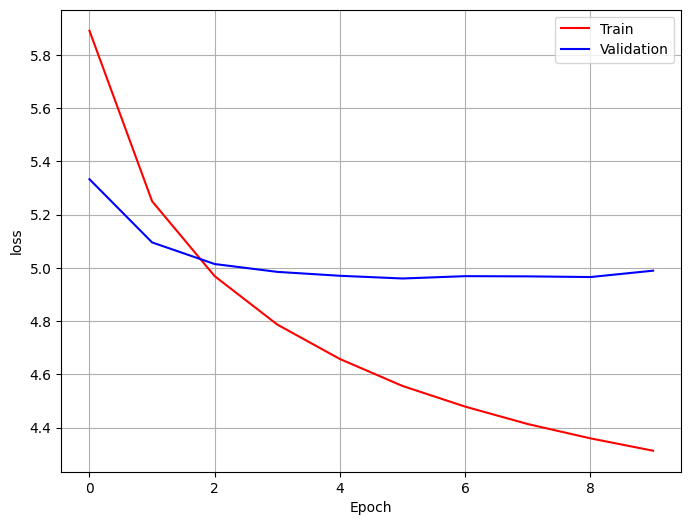

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(10), loss_train_hist2, 'r-', label='Train')
plt.plot(range(10), loss_valid_hist2, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

#  **Test**

 Test your model using data from the test set

In [ ]:
# put your saved model path
model_path =''

model = torch.load(model_path)
model.eval()

LanguageModel(
  (Embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
loss_test, metric_test = evaluate(model, test_loader, loss_fn, metric)
metric_test

In [ ]:
test_iter =iter(test_loader)
model.eval()

In [ ]:
test_inp , test_targ = next(test_iter)
outp = model(test_inp)
loss_fn(outp.reshape(-1, outp.shape[-1]), test_targ.flatten())

#  **Generate**

use `generate` function to test the model.

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):

  indices = vocabs(tokenizer(prompt))
  itos = vocabs.get_itos()

  for i in range(max_seq_len):

    index_sample = torch.LongTensor(indices).to(device)
    with torch.no_grad():
      prediction = model(index_sample)

    # Method 1
    '''src= src[-1]
    outputs= torch.softmax(src)
    new_token = argmax(outputs)
    vocabs.get_itos()[new_token]'''

    # Method 2
    preds= torch.softmax(prediction[-1]/temprature, dim=0)

    idx= vocab['<unk>']
    while idx== vocab['<unk>']:
      idx = torch.multinomial(preds, num_samples= 1).item()

    new_token =itos[idx]
    if new_token=='.':
      propmt.append('.')
      return prompt

    propmt.append(f' {new_token}')

  return prompt

In [ ]:
# Enter a desired sentence to evaluate the model

sentence= 'this is a nice '
generate(prompt=sentence, 15,0.5, model, tokenizer, vocabs)